# Concatenation of .csv files

---

**Updated on:** 2023-09-15

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): folder of .csv files to be concatenated  
> Output file(s): concatenated .csv file  
> Dependencies: pandas, pathlib, matplotlib, numpy, ipympl, sys

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

## Importing Dependencies

In [1]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import ipympl
import sys
sys.path.append(r"..")
import microspot_util as msu
import microspot_util.plots as plots
%matplotlib widget

2023-10-06 12:40:41.664 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-06 12:40:41.672 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-06 12:40:41.676 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-06 12:40:41.680 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-06 12:40:41.684 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## User Input

In [2]:
# Input Folder containing all .csv spot files with the ending "spotlist.csv".
input_folder=Path(r"..\output")

# Folder that the output should be saved to.
output_folder=Path(r"..\output")

RT_start=60             # RT @ which spotting was started
spotting_time=1         # Time that each spot was spotted for


## Data Merging and RT Matching

In [3]:
# Loop over all files in the folder that should be concatenated.
merged_spots=[]
for file in input_folder.glob("*spotlist.csv"):
    # Create list of spot-objects from .csv
    current_list=msu.spot.df_to_list(pd.read_csv(file))
    # Add to merged spot-list
    merged_spots.extend(current_list)

# Sort the newly merged spot-list by rows and columns. If serpentine = True, even rows are sorted descendingly.
msu.spot.sort_list(merged_spots,serpentine=True,inplace=True)

# Annotates each spot with a retention time based in the input parameters.
msu.spot.annotate_RT(merged_spots,RT_start,spotting_time)

## Heatmap of concatenated spotlist

2023-10-06 12:40:42.890 
  command:

    streamlit run c:\Users\Nomis\anaconda3\envs\main\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2023-10-06 12:40:42.892 No runtime found, using MemoryCacheStorageManager


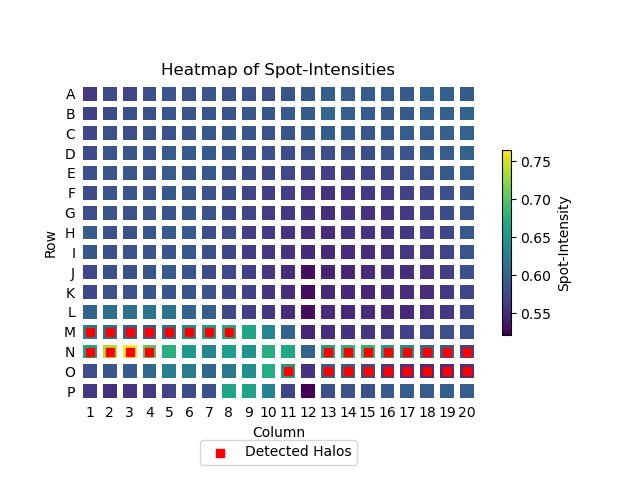

In [4]:
# Create df from list
concat_df=msu.spot.create_df(merged_spots)

# Extract information on first and last spot
first_spot=merged_spots[0].row_name+str(merged_spots[0].col)
last_spot=merged_spots[-1].row_name+str(merged_spots[-1].col)

# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

# Get the grid-properties of the spotlist.
grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

# Plot the heatmap of the merged data.
fig1,ax1=plt.subplots()
plots.plot_heatmap(fig1,ax1,concat_df,grid_props)

## Chromatogram

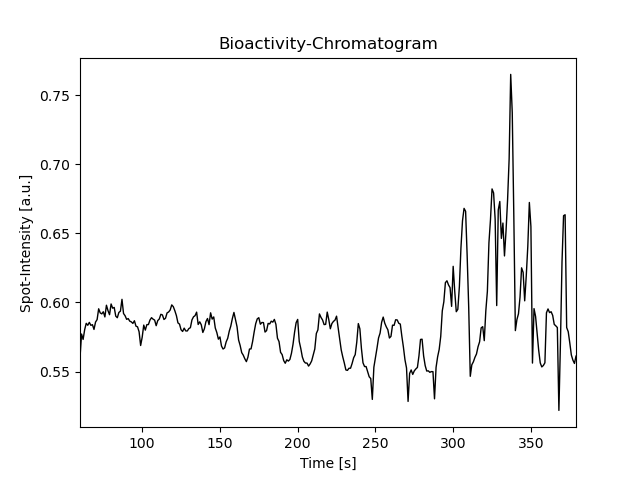

In [5]:
fig,ax=plt.subplots()
plots.plot_chromatogram(fig,ax,concat_df)

## Save output-files.

In [6]:
# Write to file.
output_filename=output_folder / Path(input_folder.name+"_concat.csv")
concat_df.to_csv(output_filename)